# Platform for Live Crypto Trading with ML

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 70 kB 8.7 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 112 kB 62.1 MB/s 
     |████████████████████████████████| 288 kB 58.7 MB/s 
     |████████████████████████████████| 144 kB 63.7 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 54.2 MB/s 


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import utils.load_crypto_assets as lc

# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [5]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [19]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [20]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [21]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (167686, 8)


In [22]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:16:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:31:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:46:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:01:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1654356600,1654356600,29860.93,29888.01,29802.53,29806.00,339.590280,8152.0,2022-06-04 15:31:00,2022-06-04 15:45:00
1654357500,1654357500,29805.99,29858.80,29795.55,29858.80,322.093930,6888.0,2022-06-04 15:46:00,2022-06-04 16:00:00
1654358400,1654358400,29858.79,29858.80,29795.94,29808.01,338.936110,7341.0,2022-06-04 16:01:00,2022-06-04 16:15:00


In [41]:
candles = ldata_df[["Date","LowBitcoin","HighBitcoin","OpenBitcoin","CloseBitcoin","VolumeBitcoin"]].copy()
candles.set_index("Date",inplace = True)
candles.rename(columns = {"LowBitcoin":"Low","HighBitcoin":"High","OpenBitcoin":"Open","CloseBitcoin":"Close","VolumeBitcoin":"Volume"},inplace=True)

#  "Wick Candles"

---

# Data Exploration


In [42]:
print('Available Dates:', candles.iloc[0].name, '-', candles.iloc[-1].name)
print(len(candles.index), 'candles')

Available Dates: 2017-08-17 04:01:00 - 2022-06-04 16:31:00
167686 candles


## Charts

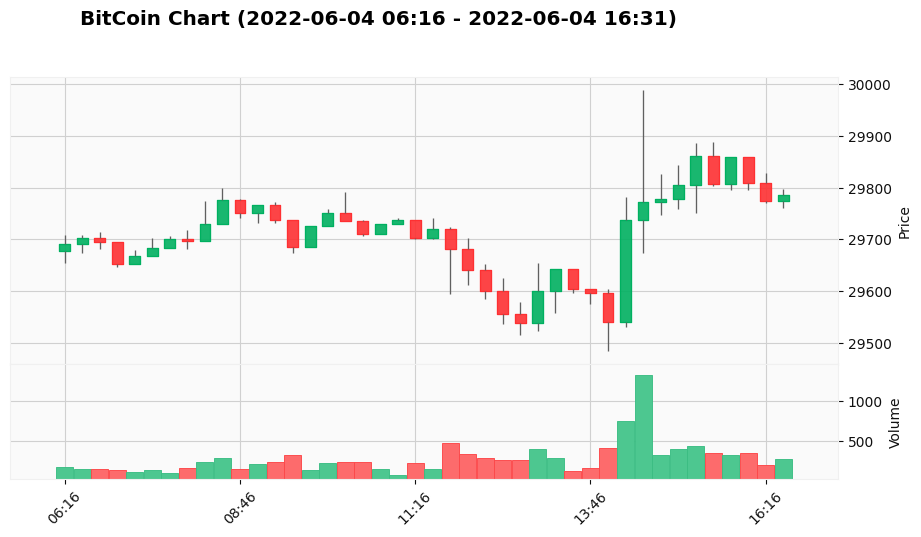

In [43]:
title = 'BitCoin Chart (' + str(candles.iloc[-42].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-42:], 
    type='candle', 
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

# Technical Analysis

## Moving Averages

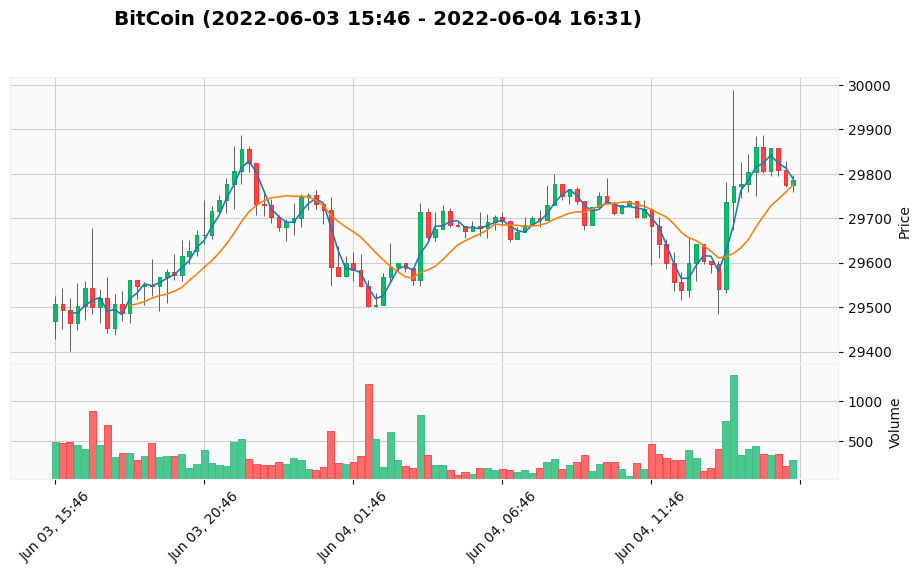

In [44]:
title = 'BitCoin (' + str(candles.iloc[-100].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-100:], 
    mav=(3, 11), 
    type='candle', 
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    title=title
)

##  Bollinger Bands

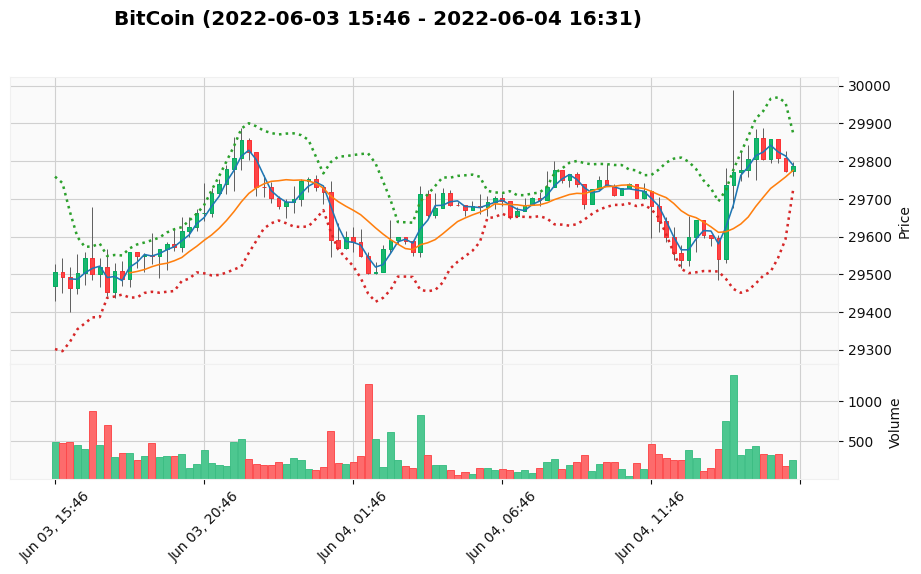

In [45]:
mean = candles['Close']
mean = mean.rolling(window=10).mean()
std_dev = candles['Close']
std_dev = std_dev.rolling(window=10).std()
candles['UpperBB'] = mean + (2 * std_dev)
candles['LowerBB'] = mean - (2 * std_dev)
bollinger_bands = candles[['UpperBB', 'LowerBB']]

bollinger_bands_plot = mpf.make_addplot(bollinger_bands[-100:], linestyle='dotted')
mpf.plot(
    candles.iloc[-100:], 
    type='candle',
    mav=(3, 11),
    volume=True, 
    figratio=(24,12), 
    style='yahoo', 
    addplot=bollinger_bands_plot, 
    title=title
)

## Price to Volume Ratio

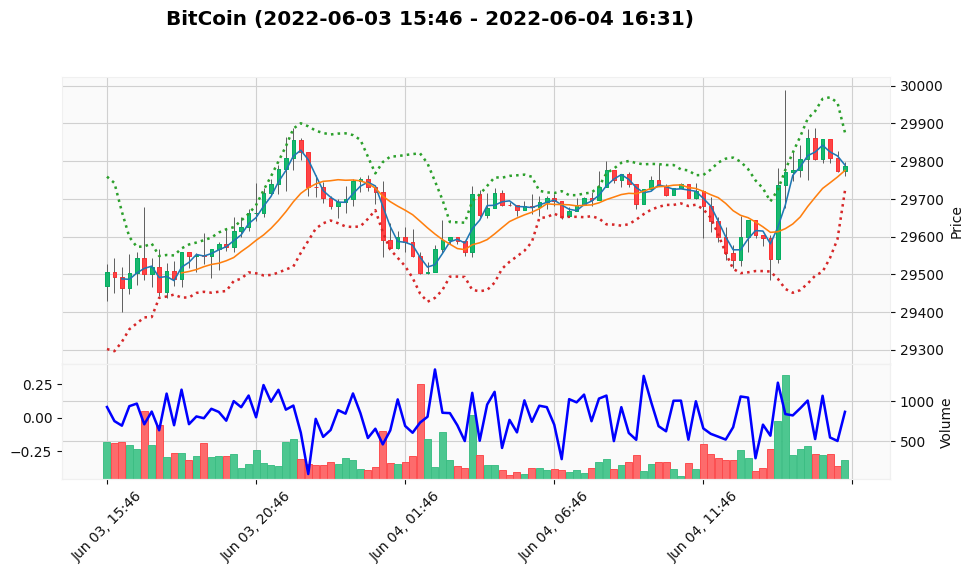

In [46]:
price_over_volume = (candles['Close'] - candles['Open']) / candles['Volume']

candles['price_over_vol'] = price_over_volume

price_over_volume_plot = mpf.make_addplot(price_over_volume[-100:], panel=1, color='blue')
mpf.plot(
    candles.iloc[-100:],
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[bollinger_bands_plot, price_over_volume_plot],
    title=title
)

## Volume Acceleration

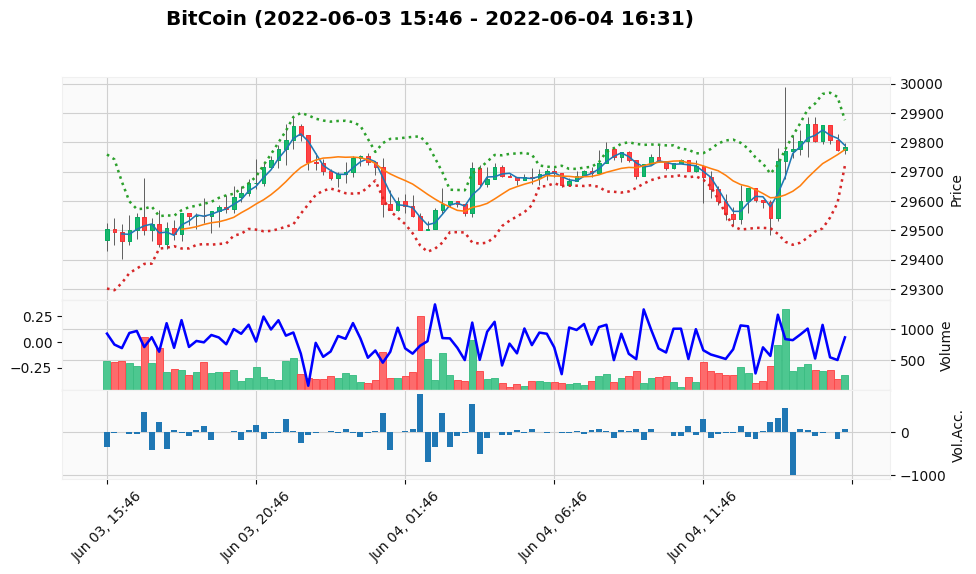

In [47]:
volume_diff = candles['Volume'] - candles['Volume'].shift(1)
volume_diff_plot = mpf.make_addplot(volume_diff[-100:], panel=2, type='bar', ylabel='Vol.Acc.')
candles['vol_diff'] = volume_diff

mpf.plot(
    candles.iloc[-100:],  
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[
        bollinger_bands_plot, 
        price_over_volume_plot, 
        volume_diff_plot
    ], 
    title=title
)

# Generate timeseries
## Normalize data

In [48]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
candles=candles.iloc[10:]
candles.fillna(method="pad",inplace=True)
candles_norm = scaler.fit_transform(candles)

print(candles.iloc[0])
print('  ------')
print(candles_norm[0])

Low               4319.830000
High              4345.450000
Open              4328.650000
Close             4345.450000
Volume               3.494176
UpperBB           4354.619977
LowerBB           4264.944023
price_over_vol       4.808001
vol_diff            -0.006737
Name: 2017-08-17 06:31:00, dtype: float64
  ------
[0.21373221 0.21329801 0.21364707 0.213889   0.20010069 0.21189874
 0.21480829 0.58336266 0.43370488]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Remove NaNs
due to Bolliger Bands and moving averages

In [49]:
candles_norm = candles_norm[10:]
TEST=False
if not TEST:
    RECENT_DATA = 60000
    candles_norm = candles_norm[-RECENT_DATA:]
    print(len(candles_norm))


60000


## Generate dataset based on timeseries

In [50]:
x_candles = []
x_time = []
y = []

step_back = 48

for i in range(len(candles_norm) - step_back):
    example_candles = []
    example_time = []

    if (TEST or crypto.kline_size=="1h" or crypto.kline_size=="15m"):
        for o in range(0, step_back):
            example_candles.append(candles_norm[i + o])
            t = candles.iloc[10 + i + o].name
            example_time.append([t.hour / 24, t.weekday() / 7])
    elif(crypto.kline_size=="1m"):
        for o in range(0, step_back):
            example_candles.append(candles_norm[i + o])
            t = candles.iloc[10 + i + o].name
            example_time.append([t.minute / 60., t.hour/24])  

    x_candles.append(example_candles)
    x_time.append(example_time)
    y.append(candles_norm[i+step_back][3])

In [51]:
candles.iloc[10 + i + o].name.minute/60

0.7666666666666667

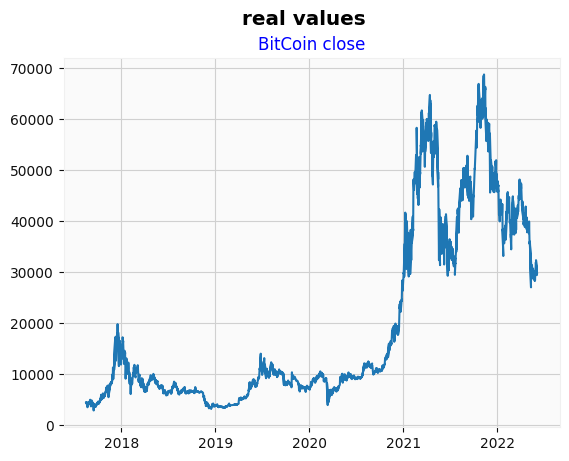

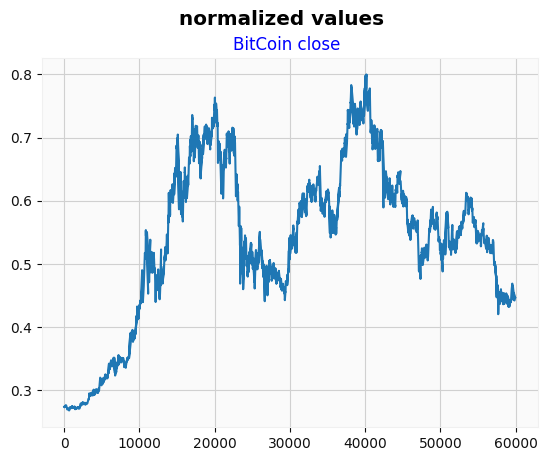

In [52]:
plt.plot(candles['Close'])
plt.title('BitCoin close', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('real values')
plt.show()

plt.plot(y)
plt.title('BitCoin close ', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('normalized values')
plt.show()

In [53]:
np.shape(x_candles)

(59952, 48, 9)

### Create training and validation datasets

In [54]:
split_point = int(len(x_candles) * 0.9)

x_train_candles = np.asarray(x_candles[:split_point], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point], dtype=np.float32)
y_train = np.asarray(y[:split_point], dtype=np.float32)

x_test_candles = np.asarray(x_candles[split_point:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point:], dtype=np.float32)
y_test = np.asarray(y[split_point:], dtype=np.float32)

In [55]:
print(x_train_candles.shape)
print(x_train_time.shape)
print(y_train.shape)
print('from', candles.iloc[0].name, 'to', candles.iloc[split_point + step_back].name)

print('   --------')

print(x_test_candles.shape)
print(x_test_time.shape)
print(y_test.shape)
print('from', candles.iloc[split_point + step_back + 1].name, 'to', candles.iloc[-step_back].name)

(53956, 48, 9)
(53956, 48, 2)
(53956,)
from 2017-08-17 06:31:00 to 2019-03-05 20:46:00
   --------
(5996, 48, 9)
(5996, 48, 2)
(5996,)
from 2019-03-05 21:01:00 to 2022-06-04 04:46:00


## Implement predictive model
---

#### Use the"Swish" activation function

In [56]:
def swish(x):
    return keras.backend.sigmoid(x) * x

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['Candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['Candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['Candles[0][0]']                
                                                                                              

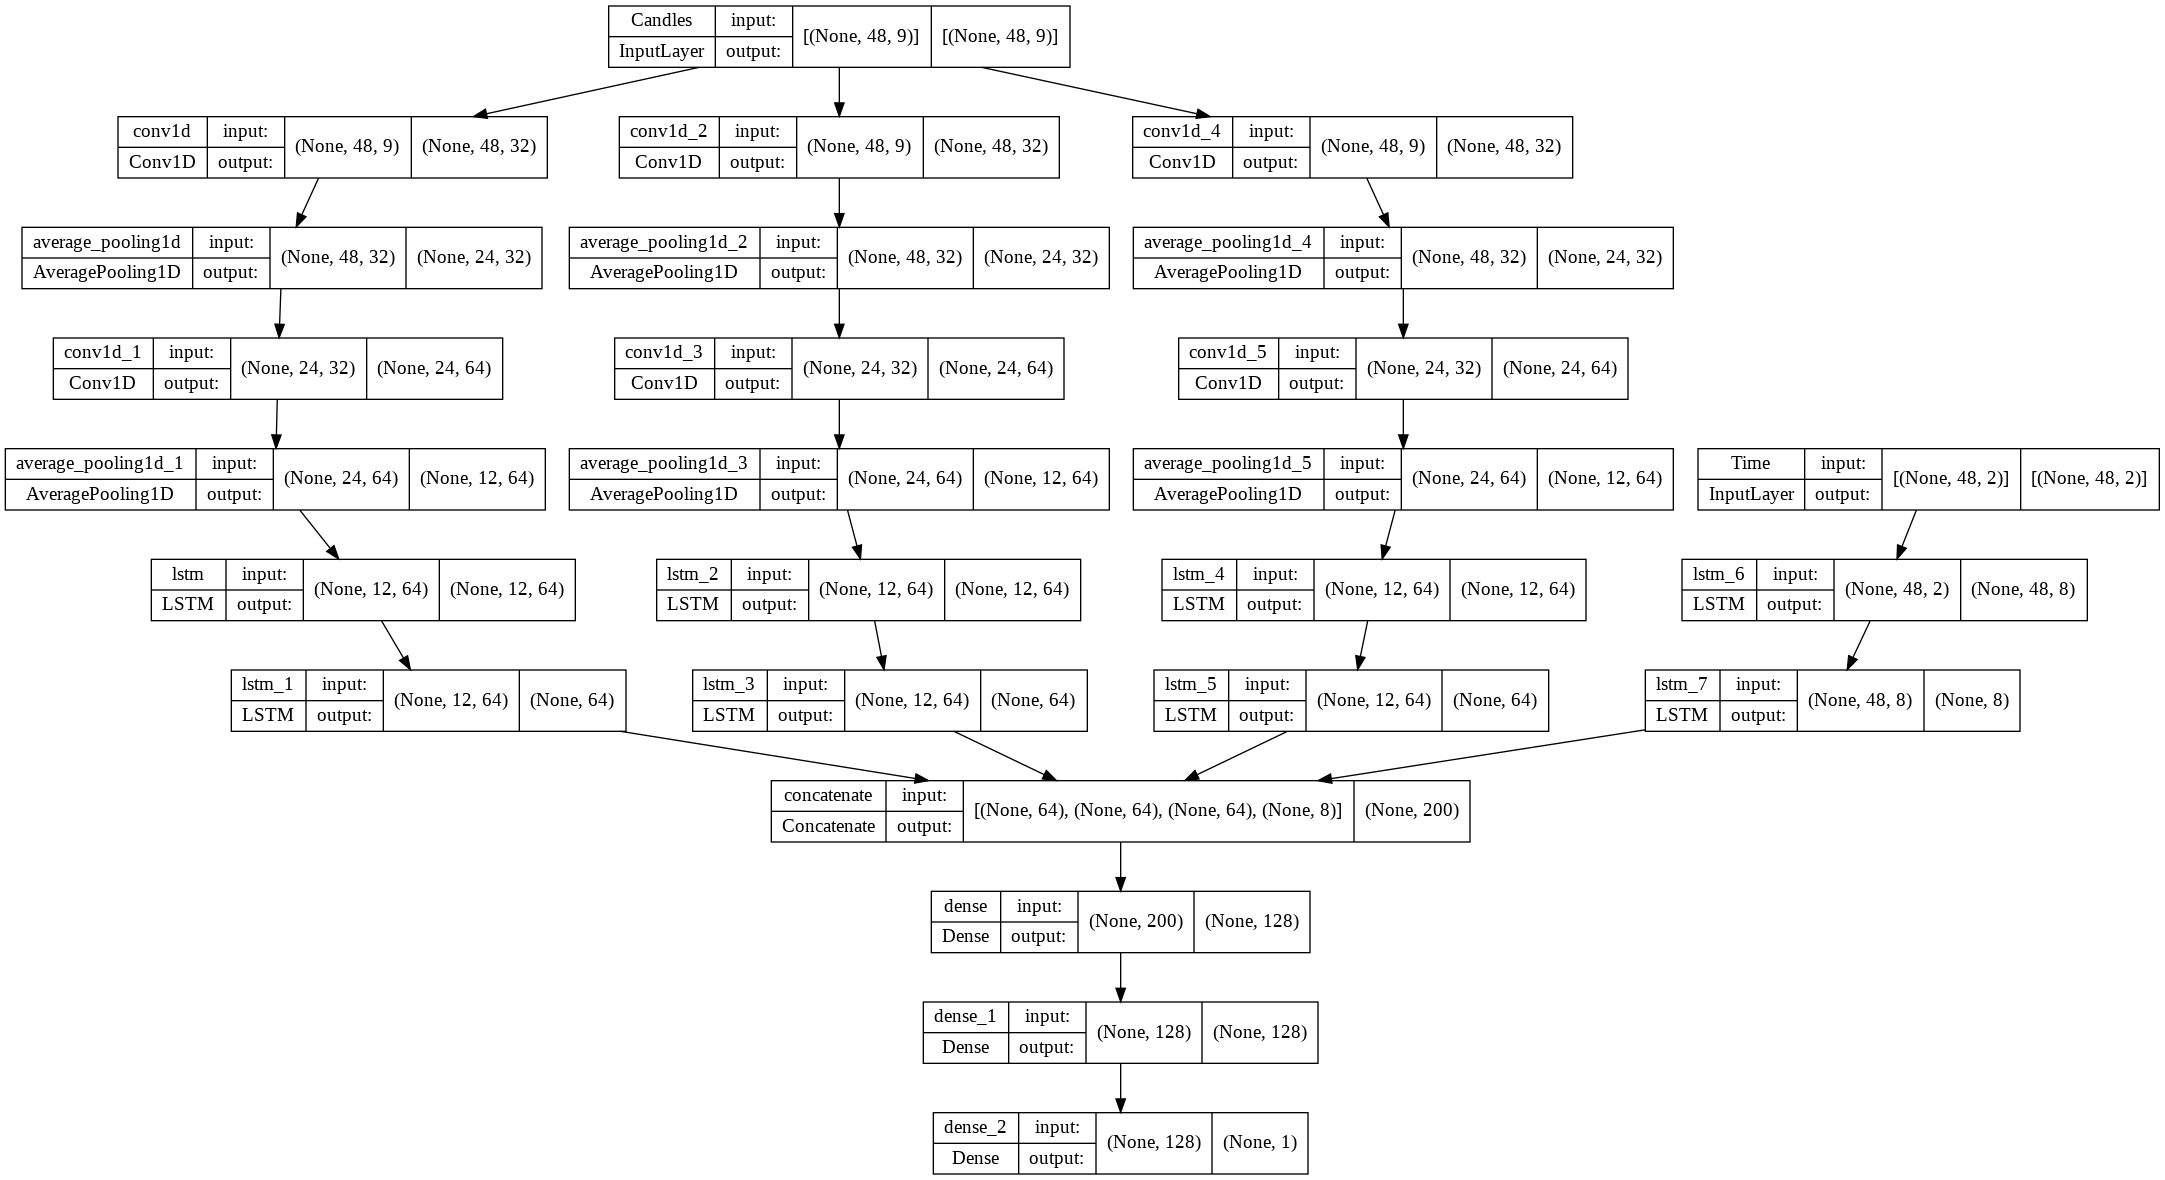

In [57]:
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D()(conv_1)
    
    conv_2 = keras.layers.Conv1D(
        filters=64,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D()(conv_2)
    
    lstm_1 = keras.layers.LSTM(units=64, return_sequences=True)(average_2)
    lstm_2 = keras.layers.LSTM(units=64)(lstm_1)
    
    return lstm_2


input_candles = keras.Input(shape=(x_train_candles.shape[1], x_train_candles.shape[2]), name='Candles')
input_time = keras.Input(shape=(x_train_time.shape[1], x_train_time.shape[2]), name='Time')

conv_1 = get_conv_lstm_block(input_candles, kernel_size_1=3, kernel_size_2=3)
conv_2 = get_conv_lstm_block(input_candles, kernel_size_1=7, kernel_size_2=7)
conv_3 = get_conv_lstm_block(input_candles, kernel_size_1=13, kernel_size_2=13)

lstm_time_1 = keras.layers.LSTM(units=8, return_sequences=True)(input_time)
lstm_time_2 = keras.layers.LSTM(units=8)(lstm_time_1)

conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, lstm_time_2])

dense_1 = keras.layers.Dense(units=128, activation=keras.activations.swish)(conc)
dense_2 = keras.layers.Dense(units=128, activation=keras.activations.swish)(dense_1)

output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_2)

model = keras.Model(inputs=[input_candles, input_time], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_absolute_error)

model.summary()
keras.utils.plot_model(model, "conv_lstm_net.png", show_shapes=True)

In [58]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time],
    y_train,
    epochs=20,
    batch_size=4096,
    validation_data=(
        [x_test_candles, x_test_time],
        y_test
    ),
    callbacks=model_checkpoint_callback
)

model.load_weights('weights/weights')

Epoch 1/20
14/14 [==============================] - 31s 376ms/step - loss: 0.1773 - val_loss: 0.0409
Epoch 2/20
14/14 [==============================] - 1s 94ms/step - loss: 0.0492 - val_loss: 0.0179
Epoch 3/20
14/14 [==============================] - 1s 97ms/step - loss: 0.0159 - val_loss: 0.0064
Epoch 4/20
14/14 [==============================] - 1s 94ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 5/20
14/14 [==============================] - 1s 95ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 6/20
14/14 [==============================] - 1s 96ms/step - loss: 0.0098 - val_loss: 0.0059
Epoch 7/20
14/14 [==============================] - 1s 95ms/step - loss: 0.0091 - val_loss: 0.0062
Epoch 8/20
14/14 [==============================] - 1s 96ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 9/20
14/14 [==============================] - 1s 95ms/step - loss: 0.0086 - val_loss: 0.0054
Epoch 10/20
14/14 [==============================] - 1s 95ms/step - loss: 0.0082 - val_loss: 0.0053
Epoch 1

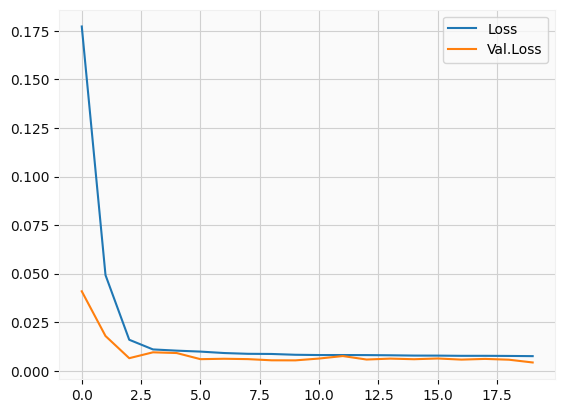

In [59]:

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Utilizzo e validazione del modello predittivo

In [60]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

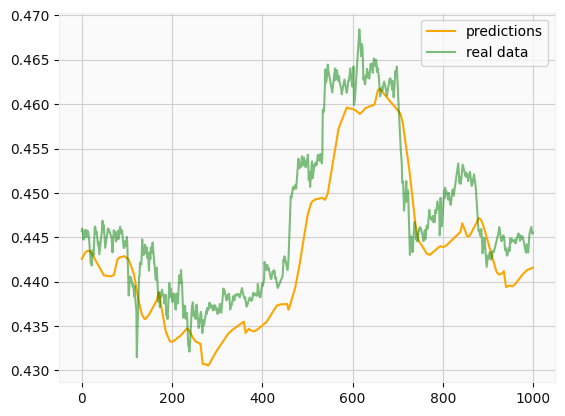

In [61]:
plt.plot(preds[-1000:], color='orange', label='predictions')
plt.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [62]:
def log_return(series, periods=1):
    log_ret = np.log(series).diff(periods=periods)
    if periods < 0:
        log_ret*= -1.
    return log_ret

In [63]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


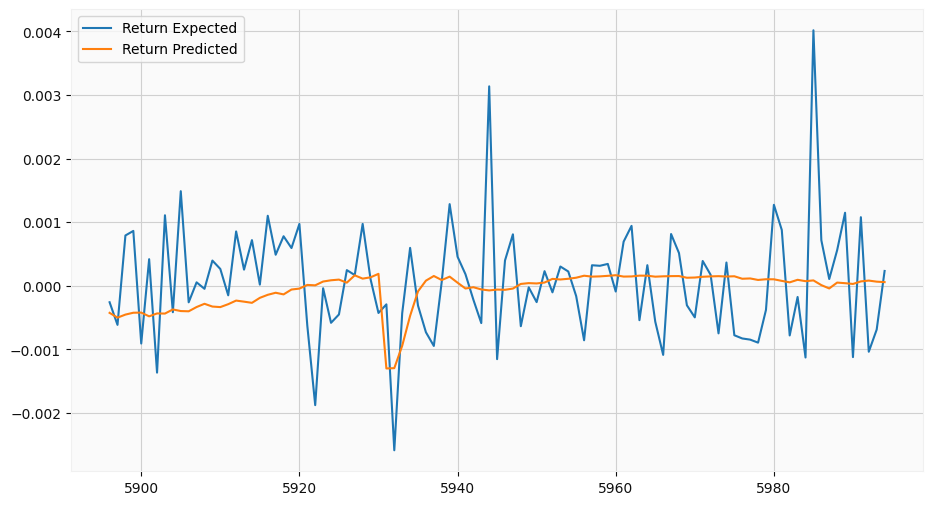

In [64]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [65]:
def denorm(value):
    example = [0.5 for x in range(9)]
    example[3] = value
    return scaler.inverse_transform([example])[0][3]

In [66]:
def backtesting(fee=0.025):
    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    for i in range(split_point, len(x_candles)):
        prediction = preds[i - split_point][0]
        predicted_close = denorm(prediction)
        previous_close = denorm(candles_norm[i][3])
        real_next_close = denorm(candles_norm[i+1][3])

        if (previous_close + (previous_close * fee)) < predicted_close:  # buy
            profit = real_next_close - previous_close
            if profit > 0:
                profit = profit - (profit * fee)
                buys_cnt_win += 1
                old_profit_negative = False
            else:
                profit = profit + (profit * fee)
                buys_cnt_losses += 1
                if old_profit_negative:
                    old_profits += profit
                else:
                    old_profits = profit
                if old_profits < drawback:
                    drawback = old_profits
                old_profit_negative = True
            wallet += profit
            total_wallet_history.append(wallet)
            single_wallet_history.append(profit)
            buys_cnt += 1
        else:
            old_profit_negative = False
            old_profits = 0

    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('No-op   ', (len(x_candles) - split_point) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      28 ( 22 ok 6 ko )
No-op    5968
Wallet   3782.9209999999875
Drawback -243.32475000000312


Total earned 3782.9209999999875


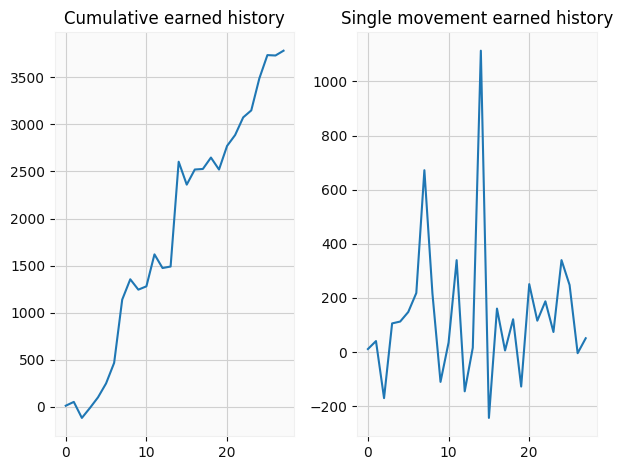

In [67]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## training on more epochs

In [68]:
preds_old = preds
y_test_old = y_test

In [69]:
many_epochs = 50
print(f'training on {many_epochs} epochs...')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time], 
    y_train, 
    epochs=many_epochs,
    initial_epoch=21, 
    batch_size=4096,
    validation_data=([x_test_candles, x_test_time], y_test),
    callbacks=model_checkpoint_callback,
    verbose=1
)

training on 50 epochs...
Epoch 22/50
14/14 [==============================] - 1s 106ms/step - loss: 0.0071 - val_loss: 0.0088
Epoch 23/50
14/14 [==============================] - 1s 87ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 24/50
14/14 [==============================] - 1s 86ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 25/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 26/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0072 - val_loss: 0.0092
Epoch 27/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 28/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 29/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 30/50
14/14 [==============================] - 1s 96ms/step - loss: 0.0070 - val_loss: 0.0086
Epoch 31/50
14/14 [==============================] - 1s 85ms/step - loss: 

In [70]:
model.load_weights('weights/weights')

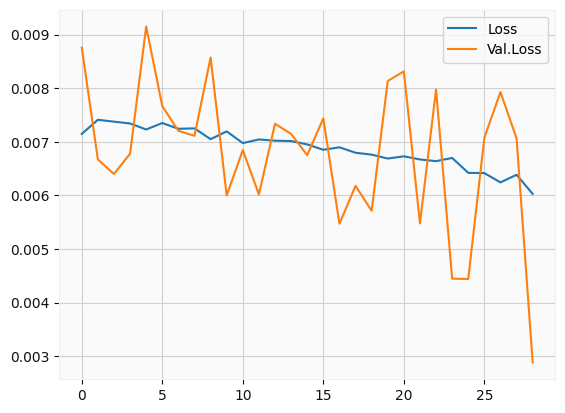

In [71]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [72]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

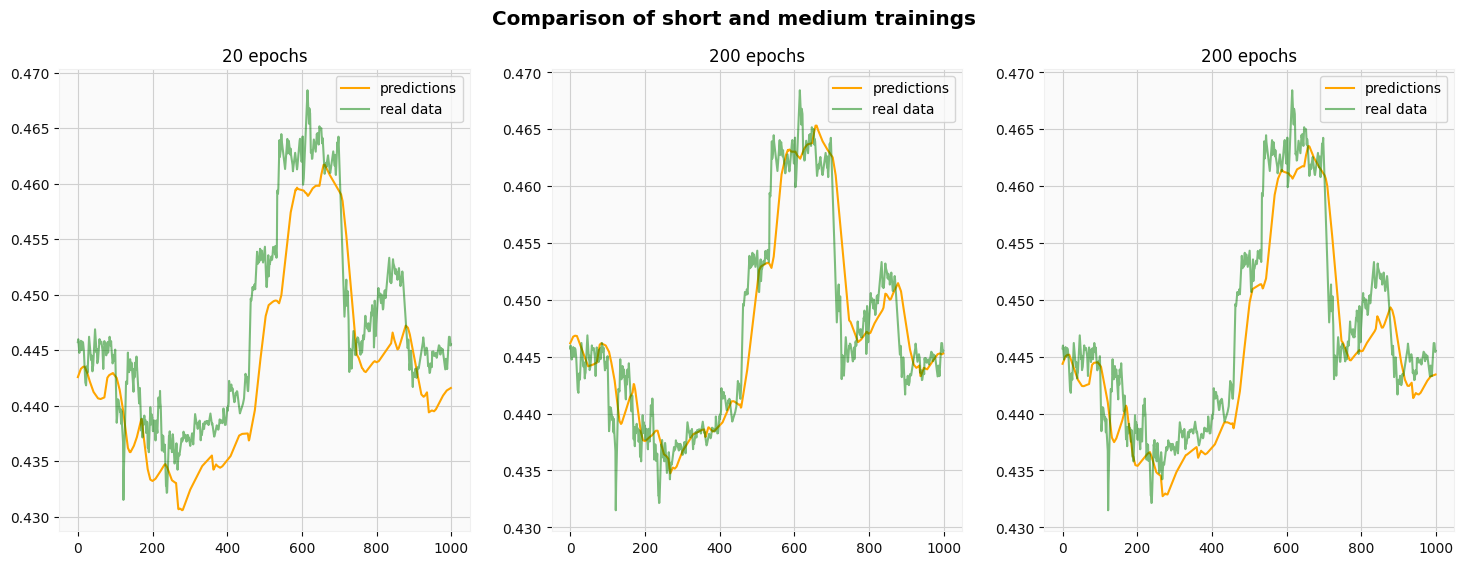

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Comparison of short and medium trainings')

ax1.set_title('20 epochs')
ax1.plot(preds_old[-1000:], color='orange', label='predictions')
ax1.plot(y_test_old[-1000:], color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('200 epochs')
ax2.plot(preds[-1000:], color='orange', label='predictions')
ax2.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('200 epochs')
ax3.plot((preds[-1000:]+preds_old[-1000:])/2, color='orange', label='predictions')
ax3.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax3.legend()


plt.show()

In [74]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


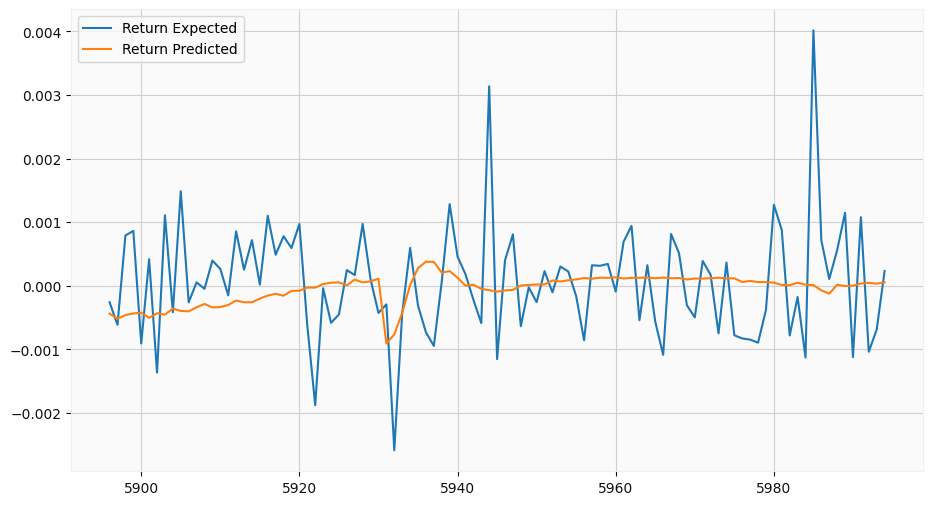

In [75]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [76]:
total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      203 ( 134 ok 69 ko )
No-op    5793
Wallet   11698.86549999998
Drawback -604.422000000004


Total earned 11698.86549999998


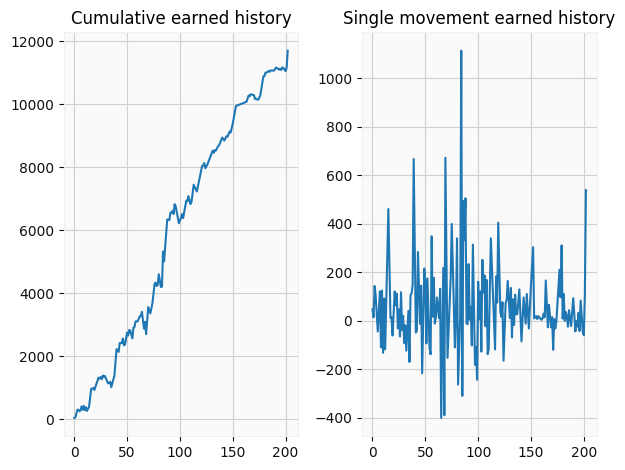

In [77]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()